<a href="https://colab.research.google.com/github/IverMartinsen/MastersThesis/blob/main/Notebooks/compute_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import modules

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/src/Python/modules')

import tensorflow as tf
from modules.imageloader import load_images
from modules.analysis.utils import compute_gradients
from modules.analysis.integrated_gradients import integrated_gradients, ig_error
from modules.analysis.guided_backpropagation import build_gb_model_nonseq
from modules.image_tools import normalize
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

Import images and set variables

In [ ]:
img_size = (128, 128)
img_shape = img_size + (3,)
initial_epochs = 100
batch_size = 32
path_to_files = r'/content/drive/MyDrive/Data/Torskeotolitter/standard'

sets = load_images(
    path_to_files, img_size, splits=1, seed=321, mode='RGB')

ds = sets[0]

Load pretrained models

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Artikkel om torskeotolitter/Saved models/Xception_2.6.0')

base_model = tf.keras.applications.Xception(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet'
    )

for layer in base_model.layers:
    layer.trainable = False

gb_base_model = build_gb_model_nonseq(base_model, tf.keras.layers.Activation)

inputs = tf.keras.Input(img_shape)
x = tf.keras.applications.xception.preprocess_input(inputs)
x = gb_base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, 'sigmoid')(x)

gb_model = tf.keras.Model(inputs, outputs)

gb_model.compile(    
    tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics='accuracy')

# Load the weights from trained model
gb_model.set_weights(model.get_weights())

Compute integrated gradients for all images from target class

In [ ]:
target_class_idx = 0

m_steps = 100

baseline = np.zeros_like(ds['images'][0])

# store target class indices
idxs = np.where(
    np.argmax(model.predict(ds['images']), axis = 1) == target_class_idx)

# count number of images from target class
num_images = np.shape(idxs)[-1]

# TensorArray's for storage of gradients, errors and images
ig_gradients = tf.TensorArray(tf.float32, size=9)
ig_errors = tf.TensorArray(tf.float32, size=9)

for i, image in enumerate(ds['images'][idxs][:9]):
    
    ig = integrated_gradients(
            gb_model, baseline, image, target_class_idx, m_steps, batch_size)

    ig_gradients = ig_gradients.write(i, ig)
    
    ig_errors = ig_errors.write(i, ig_error(
        model, baseline, image, ig, target_class_idx))

Display and save figure

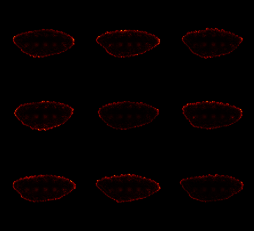

In [ ]:
destination = '/content/drive/MyDrive/Artikkel om torskeotolitter/cc2/'

# display a random selection of heatmaps and save figure
fig, ax = plt.subplots(3, 3, facecolor='black')
for i, ax in enumerate(ax.flatten()):
    ax.imshow(
        normalize(
            tf.abs(
                tf.reduce_sum(ig_gradients.stack()[i], axis = 2))), 
              plt.cm.afmhot, vmin = 0, vmax = 1)
    #ax.imshow(tf.reduce_sum(ds['images'][idxs][i], axis = 2), 'gray', alpha = 0.3)
    ax.axis('off')
    ax.patch.set_facecolor('black')
plt.subplots_adjust(wspace=-0.5, hspace=0)

plt.savefig(
    destination + 'cc_selection_gb_ig_combined.jpg', 
    dpi=300, 
    bbox_inches="tight", 
    pad_inches=0, 
    facecolor='black')

Save filenames and errors to txt files

In [ ]:
# list all filenames belonging to target class for storage
filenames = np.array(ds['filenames'])[idxs]

# write filenames to text file
with open(destination + 'cc_filenames.txt', 'w') as f:
    for item in filenames[:9]:
        f.write("%s\n" % item)

# write errors to text file
with open(destination + 'cc_errors.txt', 'w') as f:
    for item in ig_errors.stack():
        f.write("%s\n" % float(item.numpy()))

Compute gradients by guided backpropagation for all images classified as target class


In [ ]:
# compute gradients of inputs wrt outputs
gb_gradients = compute_gradients( 
    tf.convert_to_tensor(ds['images'][idxs][:9]),
    gb_model,
    target_class_idx)

Display and save figure

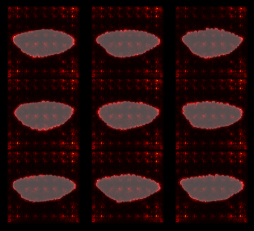

In [ ]:
# display a random selection of heatmaps and save figure
fig, ax = plt.subplots(3, 3, facecolor='black')
for i, ax in enumerate(ax.flatten()):
    ax.imshow(
        normalize(
            tf.abs(tf.reduce_sum(
                gb_gradients[i], axis = 2))), 
              plt.cm.hot, vmin = 0, vmax = 1)
    ax.imshow(tf.reduce_sum(ds['images'][idxs][i], axis = 2), 'gray', alpha = 0.3)
    ax.axis('off')
    ax.patch.set_facecolor('black')
plt.subplots_adjust(wspace=-0.5, hspace=0)


plt.savefig(
    destination + 'cc_selection_gb_overlay.jpg', 
    dpi=300, 
    bbox_inches="tight", 
    pad_inches=0, 
    facecolor='black')

Compute ordinary gradients

In [ ]:
# compute gradients of inputs wrt outputs
vanilla_gradients = compute_gradients( 
    tf.convert_to_tensor(ds['images'][idxs][:9]),
    model,
    target_class_idx)

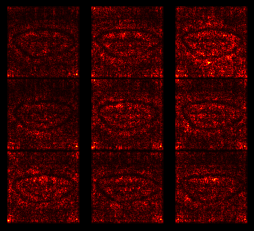

In [ ]:
# display a random selection of heatmaps and save figure
fig, ax = plt.subplots(3, 3, facecolor='black')
for i, ax in enumerate(ax.flatten()):
    ax.imshow(
        normalize(
            tf.abs(tf.reduce_sum(
                vanilla_gradients[i], axis = 2))), 
              plt.cm.hot, vmin = 0, vmax = 1)
    #ax.imshow(tf.reduce_sum(ds['images'][idxs][i], axis = 2), 'gray', alpha = 0.3)
    ax.axis('off')
    ax.patch.set_facecolor('black')
plt.subplots_adjust(wspace=-0.5, hspace=0)

plt.savefig(
    destination + 'neac_selection_vanilla.jpg', 
    dpi=300, 
    bbox_inches="tight", 
    pad_inches=0, 
    facecolor='black')

Compare visualization methods

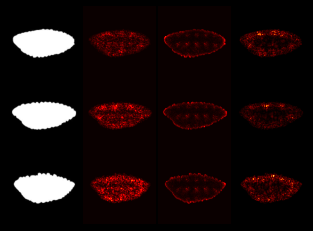

In [ ]:
# display a random selection of heatmaps and save figure
fig, ax = plt.subplots(3, 4, facecolor='black')

for i, axes in enumerate(ax):

    axes[0].imshow(
        tf.reduce_sum(ds['images'][idxs][i], axis = 2), 'gray')
    axes[0].axis('off')
    axes[0].patch.set_facecolor('black')


    axes[1].imshow(
        normalize(
            tf.abs(tf.reduce_sum(
                vanilla_gradients[i], axis = 2)))*normalize(tf.reduce_sum(ds['images'][idxs][i], axis = 2)), 
              plt.cm.hot, vmin = 0, vmax = 1)
    axes[1].axis('off')
    axes[1].patch.set_facecolor('black')


    axes[2].imshow(
        normalize(
            tf.abs(tf.reduce_sum(
                gb_gradients[i], axis = 2)))*normalize(tf.reduce_sum(ds['images'][idxs][i], axis = 2)), 
              plt.cm.hot, vmin = 0, vmax = 1)    
    axes[2].axis('off')
    axes[2].patch.set_facecolor('black')

    axes[3].imshow(
        normalize(
            tf.abs(
                tf.reduce_sum(ig_gradients.stack()[i], axis = 2))), 
              plt.cm.afmhot, vmin = 0, vmax = 1)

    axes[3].axis('off')
    axes[3].patch.set_facecolor('black')

plt.subplots_adjust(wspace=-0.3, hspace=0)

plt.savefig(
    destination + 'cc_comparison.jpg', 
    dpi=300, 
    bbox_inches="tight", 
    pad_inches=0, 
    facecolor='black')